# TP8: EM + KMeans

**Alumna**: Lucia Berard

**Fecha**: 01/06/2025

[Link a Google Colab](https://colab.research.google.com/drive/1AR-mJnZDkuaja74O0NeDQ9wXQuYzKCIl?usp=sharingg)


En el archivo `instrumentos.zip` encontrará audios de diferentes instrumentos musicales. Se desea clasificar entre las 5 clases de instrumentos presentes en la base de datos.



---

## (a) Exploración de datos

#### a.1) Utilizando `load` ([librosa](https://librosa.org/doc/latest/index.html)), construir 5 conjuntos de datos de entrenamiento y 5 de testeo (uno por instrumento). Reservar el último archivo de cada instrumento para el conjunto de testeo, y utilizar el resto para entrenamiento.


In [2]:
%pip install librosa

     |████████████████████████████████| 260 kB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 43.3 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 34.4 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 16.7 MB/s eta 0:00:01
     |████████████████████████████████| 160 kB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 11.7 MB/s eta 0:00:01
You should consider upgrading via the '/Users/luberard/Documents/fiuba/taller-procesamiento-tde/venv-taller/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Imports genericos
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Imports del tp
import librosa
from IPython.display import Audio
from scipy.signal import stft
from sklearn.mixture import GaussianMixture
from scipy.special import softmax
from collections import defaultdict

In [27]:
# Descomprimir instrumentos.zip 
# Supongo que el archivo existe y conozco su estructura
![ -d instrumentos ] || unzip -d instrumentos instrumentos.zip

In [ ]:
# Buscar todos los archivos .mp3 en la carpeta instrumentos (no recursivo porque ya se que no hay subcarpetas)
audio_files = [os.path.join('instrumentos', f) for f in os.listdir('instrumentos') if f.lower().endswith('.mp3')]

# Agrupar por instrumento: se asume que el nombre del instrumento es el prefijo antes del primer guion bajo
inst_files = defaultdict(list)
for f in audio_files:
    base = os.path.basename(f)
    inst = base.split('_')[0].lower()
    inst_files[inst].append(f)

# Separar en train y test: el último archivo de cada instrumento para test (enunciado)
train_files = {}
test_files = {}
for inst, files in inst_files.items():
    files = sorted(files)
    train_files[inst] = files[:-1]
    test_files[inst] = [files[-1]]

# Cargar audios con librosa
train_data = {inst: [librosa.load(f, sr=None)[0] for f in files] for inst, files in train_files.items()}
test_data = {inst: [librosa.load(f, sr=None)[0] for f in files] for inst, files in test_files.items()}

# Verificar las claves (instrumentos) y la cantidad de archivos en cada conjunto
print("Instrumentos encontrados:", list(train_data.keys()))
for inst in train_data:
    print(f"{inst}: {len(train_data[inst])} archivos para entrenamiento, {len(test_data[inst])} para testeo")


Instrumentos encontrados: ['trumpet', 'guitar', 'clarinet', 'violin', 'saxophone']
trumpet: 4 archivos para entrenamiento, 1 para testeo
guitar: 4 archivos para entrenamiento, 1 para testeo
clarinet: 4 archivos para entrenamiento, 1 para testeo
violin: 4 archivos para entrenamiento, 1 para testeo
saxophone: 4 archivos para entrenamiento, 1 para testeo



#### a.2) Graficar la señal temporal de la señal de testeo de la guitarra en función del tiempo (en segundos).


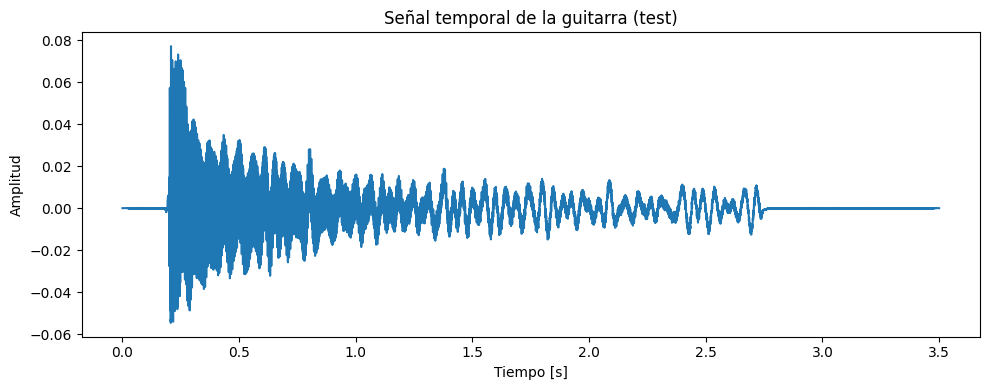

In [32]:
# Obtener la señal y la frecuencia de muestreo del archivo de testeo de guitarra
instrumentos = train_data.keys()
signals = {}
for inst in instrumentos:
    test_file = test_files[inst][0]
    signal, sr = librosa.load(test_file, sr=None)
    signals[inst] = signal

# Crear el eje temporal en segundos
t = np.arange(len(signals['guitar'])) / sr

# Graficar la señal temporal
plt.figure(figsize=(10, 4))
plt.plot(t, signals['guitar'])
plt.title('Señal temporal de la guitarra (test)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.tight_layout()
plt.show()



#### a.3) Reproducir el audio de testeo de la guitarra utilizando `Audio` (IPython).


In [ ]:
Audio(signals['guitar'], rate=sr)

#### a.4) Utilizando [`ShortTimeFFT`](https://docs.scipy.org/doc/scipy-1.15.2/reference/generated/scipy.signal.ShortTimeFFT.html) (scipy.signal). Extraer un espectrograma de cada señal. 

🛈 *Una buena selección de criterios es utilizar una FFT de 64 puntos, un solapamiento del 50%, descartar la parte simétrica del espectro y utilizar ventana de _hamming_ de la misma cantidad de puntos de la FFT.*

La funcion de ShortTimeFFT que se usa es `scipy.signal.stft` la cual:
- Divide la señal en ventanas (segmentos cortos).
- Calcula la FFT (transformada rápida de Fourier) para cada ventana.
- Devuelve las frecuencias, los tiempos y la matriz compleja de la STFT (que luego puedes convertir en espectrograma tomando el módulo).

Se aprovecho el calculo del espectrograma para generar las matrices de características de cada señal. Cada columna de la matriz es un vector de características (espectrograma) para un instante de tiempo. Esto es lo que se va a utilizar luego para entrenar los Kmeans.

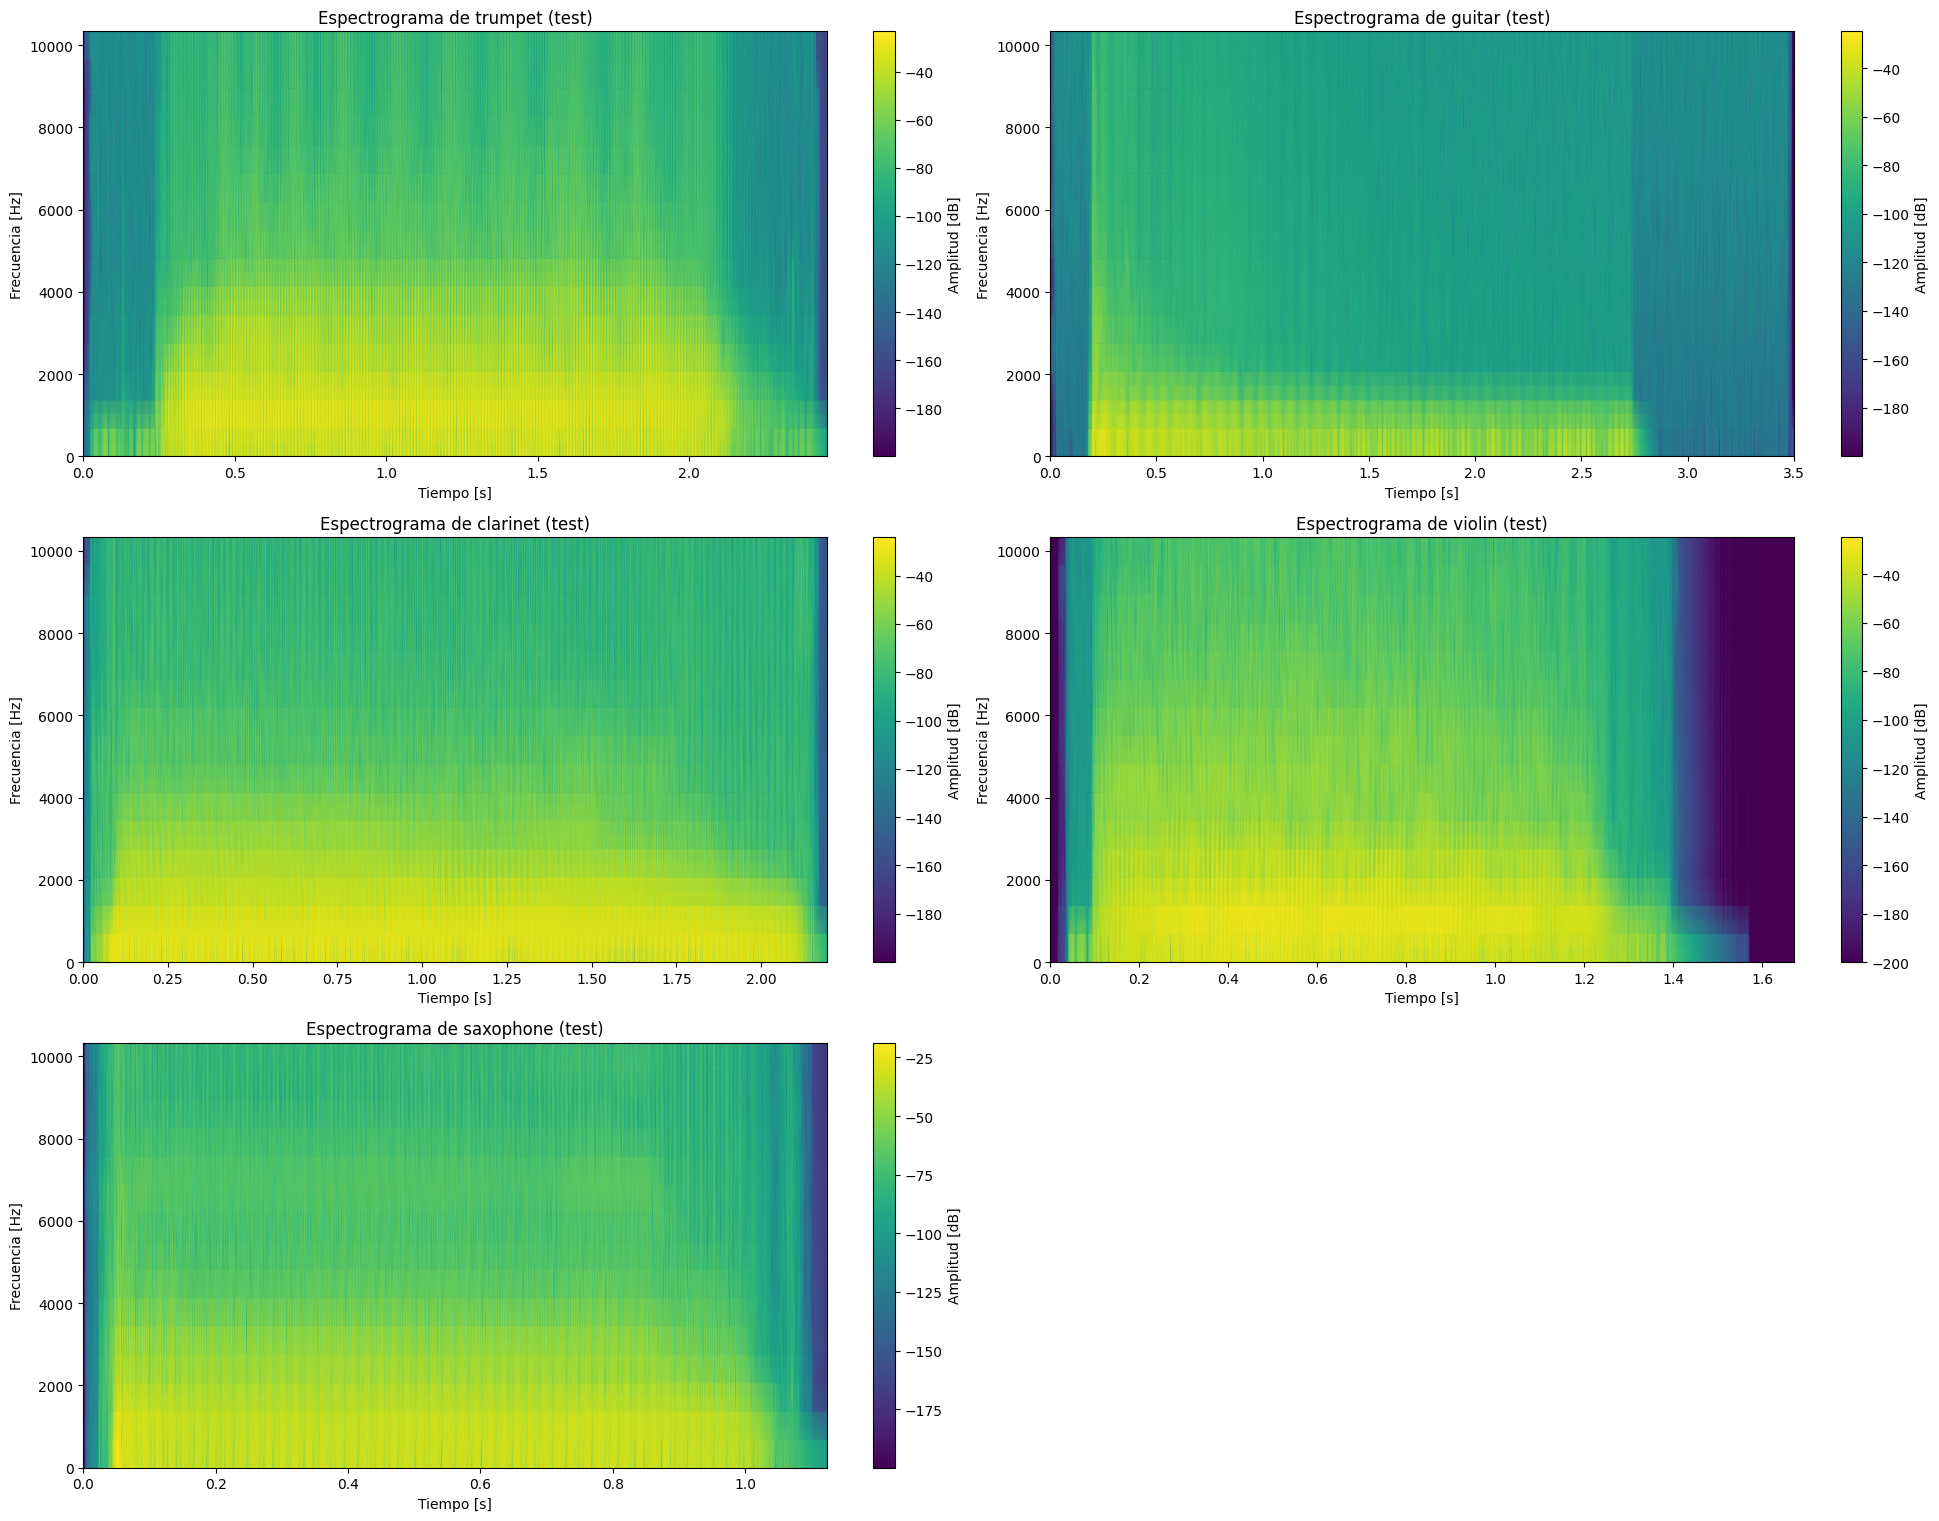

In [43]:
spectrograms = {}

plt.figure(figsize=(20, 25))
for i, inst in enumerate(signals.keys()):
    f, t, Zxx = stft(signals[inst], fs=sr, window='hamming', nperseg=64, noverlap=32, nfft=64)

    # Descarto la parte simétrica del espectro (solo frecuencias positivas)
    Zxx = Zxx[:len(f)//2, :]
    f = f[:len(f)//2]

    # Módulo del espectrograma
    # Esto es porque la STFT devuelve un espectrograma complejo (fase y magnitud) pero para este caso 
    # solo necesito la magnitud
    spectrogram = np.abs(Zxx)
    # Filas: frecuencias
    # Columnas: tiempos (frames)

    # Guarda el espectrograma como matriz de características (cada columna es un vector en el tiempo)
    # Transponemos para que cada fila sea un vector de características
    spectrograms[inst] = spectrogram.T
    # Cada fila: un frame temporal (un vector de características para un instante de tiempo)
    # Cada columna: la energía en una frecuencia específica
    # Es una matriz de forma (n_samples, n_features)

    # Graficar el espectrograma
    plt.subplot(5, 2, i+1)
    # 20 * np.log10(spectrogram + 1e-10) para pasar a dB y evitar log(0)
    # shading='gouraud' para suavizar los resultados
    plt.pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), shading='gouraud', cmap='viridis')
    plt.title('Espectrograma de ' + inst + ' (test)')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Amplitud [dB]')
    plt.tight_layout()
plt.show()



---
## (b) Entrenamiento

#### b.1) Entrenar 5 algoritmos KMeans (uno por cada instrumento). El código debe estar estructurado de la siguiente manera:

  ```python
  class Kmeans:
      # Inicializar atributos y declarar hiperparámetros
      def __init__(self, ...):
          …

      # Etapa de entrenamiento
      def fit(self, X):
          …

      # Etapa de testeo
      def predict(self, X):
          …
```


**¿Qué es Kmeans?**

KMeans es un algoritmo de aprendizaje no supervisado que sirve para agrupar datos en un número fijo de grupos (clusters). El objetivo es encontrar agrupaciones de datos (clusters) de tal manera que los puntos dentro de un mismo grupo sean lo más parecidos posible entre sí y lo más diferentes posible de los de otros grupos.    

**¿Qué es una fila de spectrograms[instrumento]?**

Cada fila de spectrograms[instrumento] es un vector de características que describe cómo es el contenido frecuencial de la señal en un momento específico.

In [ ]:
class Kmeans:
    def __init__(self, n_clusters=6, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters # Cantidad de clusters
        self.max_iter = max_iter # Cantidad de iteraciones
        self.tol = tol # Tolerancia
        self.random_state = random_state # Semilla para la inicialización aleatoria

    def fit(self, X):
        np.random.seed(self.random_state)
        # Inicialización aleatoria de los centroides
        idx = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[idx]
        for i in range(self.max_iter):
            # Asignar cada punto al centroide más cercano
            labels = np.argmin(np.linalg.norm(X[:, None] - self.centroids[None], axis=2), axis=1)
            # Actualización: Calcular nuevos centroides (promedio de los puntos de cada cluster)
            new_centroids = np.array([X[labels == j].mean(axis=0) if np.any(labels == j) else self.centroids[j] for j in range(self.n_clusters)])
            # Verificar convergencia. 
            # Si la diferencia entre los centroides es menor a la tolerancia, se detiene
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break
            self.centroids = new_centroids
        self.labels_ = labels # Etiquetas de los clusters

    def predict(self, X):
        # Asignar cada punto al centroide más cercano
        return np.argmin(np.linalg.norm(X[:, None] - self.centroids[None], axis=2), axis=1)


# Entrenar 5 algoritmos KMeans (uno por cada instrumento)
kmeans_models = {}
centroids = {}

for instrumento, X in spectrograms.items():
    kmeans = Kmeans(n_clusters=6, random_state=42)  # Ajusta los hiperparámetros según tu implementación
    kmeans.fit(X)
    kmeans_models[instrumento] = kmeans
    centroids[instrumento] = kmeans.centroids  # O el atributo correspondiente en tu clase




#### b.2) Utilizando `GaussianMixture` (sklearn), entrenar 5 mezclas de 6 gaussianas diagonales cada una (una por cada instrumento) utilizando el algoritmo EM. Inicializar dicho algoritmo utilizando el KMeans desarrollado en el ítem anterior.

🛈 *Si bien es evidente que los centroides representan las medias de las gaussianas, no es tan claro pensar como inicializar los pesos y varianzas. Justificar su criterio de inicialización*



**¿Qué es una mezcla de gaussianas (GMM)?**
- Es un modelo probabilístico que asume que los datos provienen de una combinación de varias distribuciones normales (gaussianas).
- Cada componente (gaussiana) tiene su propia media, varianza y peso.
- El modelo aprende a ajustar estos parámetros para que la combinación de todas las gaussianas explique lo mejor posible los datos observados.

**¿Qué es el algoritmo EM?**
- Es un algoritmo de optimización iterativo que busca encontrar los parámetros que maximicen la verosimilitud de los datos.
- EM = Expectation-Maximization.

**Justificación de la inicialización:**
- Medias: Se inicializan con los centroides de KMeans porque cada centroide representa el centro de un grupo (cluster) de datos, que es el rol de la media en una gaussiana.
- Pesos: Se inicializan con la proporción de muestras asignadas a cada cluster por KMeans, ya que esto refleja la "importancia" relativa de cada componente.
- Varianzas (diagonales): Se inicializan con la varianza de los puntos de cada cluster (por dimensión), porque esto representa la dispersión de los datos en cada cluster, que es lo que modela la covarianza de cada gaussiana.

Esto ayuda a que el algoritmo EM converja más rápido y a mejores soluciones, ya que comienza con una buena aproximación de los parámetros.

In [ ]:

gmm_models = {}
# Entrenar 5 algoritmos GMM (uno por cada instrumento)
for instrumento, X in spectrograms.items():
    means_init = centroids[instrumento]
    
    # Inicialización de pesos: proporción de puntos asignados a cada cluster
    labels = kmeans_models[instrumento].predict(X)
    weights_init = np.array([(labels == i).sum() for i in range(6)]) / len(X)
    
    # Inicialización de covarianzas: varianza de cada cluster (diagonal)
    covariances_init = []
    for i in range(6):
        cluster_points = X[labels == i]
        if len(cluster_points) > 1:
            cov_diag = np.var(cluster_points, axis=0)
        else:
            cov_diag = np.ones(X.shape[1]) * 1e-6  # Evitar singularidad
        covariances_init.append(cov_diag)
    covariances_init = np.array(covariances_init)
    
    gmm = GaussianMixture(
        n_components=6, # cantidad de gaussianas
        covariance_type='diag', # cada componente tendrá su propia matriz de covarianza diagonal (es decir, asume que las variables son independientes dentro de cada componente).
        means_init=means_init, # Inicializp los centroides (medias) de las gaussianas
        weights_init=weights_init, #Inicializo los pesos de mezcla (la proporción de cada componente en la mezcla)
        precisions_init=1. / covariances_init  # sklearn usa precisiones (1/var)
    )
    gmm.fit(X)
    gmm_models[instrumento] = gmm


Este código entrena, para cada instrumento, un modelo probabilístico (GMM) que describe cómo se distribuyen los vectores de características (frames del espectrograma) de ese instrumento, usando como punto de partida los clusters hallados con KMeans. Esto permite modelar de manera flexible la "huella" espectral de cada instrumento.

**¿Cuales son los clusters de KMeans?**

Cada cluster representa un grupo de frames del espectrograma (vectores de características de audio) que son similares entre sí. En este caso, un cluster podría agrupar frames que corresponden a notas similares, ataques, silencios, o patrones espectrales parecidos.

**¿Cómo se define a un cluster?**

- **Centroide**: Es el "punto medio" del cluster, calculado como el promedio de todos los puntos asignados a ese cluster.
- **Asignación**: Cada dato se asigna al cluster cuyo centroide esté más cerca.


---
---

## (c) Testeo

#### c.1) Para todas las combinaciones de desea evaluar qué tan verosímil es que las muestras de la clase i-ésima correspondan al modelo j-ésimo. Indicar las log-verosimilitud correspondientes en un cuadro de doble entrada del algoritmo EM.

Quiero saber qué tan probable es que los datos de cada instrumento (clase i) hayan sido generados por el modelo de cada instrumento (modelo j).

Esto implica:

1. Para cada combinación de conjunto de datos de instrumento (i) y modelo GMM (j), calcular la log-verosimilitud de los datos (D_i) bajo el modelo (j):

$$ \log P(D_i | \text{modelo}_j) $$

2. Organizar estos valores en una matriz (cuadro de doble entrada), donde:
- Las filas representan los instrumentos reales (los datos).
- Las columnas representan los modelos GMM entrenados (uno por instrumento).

Puedo usar la función `gmm.score(X)` en sklearn (para un modelo GaussianMixture) calcula la log-verosimilitud promedio de los datos `X` bajo el modelo GMM entrenado

In [63]:
# Lista de instrumentos
instrumentos = list(spectrograms.keys())
print(instrumentos)

# Crear la matriz de log-verosimilitud con ceros
log_likelihood_matrix = np.zeros((len(instrumentos), len(instrumentos)))

# Calcular la log-verosimilitud para cada combinación de instrumento y modelo
for i, inst_data in enumerate(instrumentos):
    X = spectrograms[inst_data]
    for j, inst_model in enumerate(instrumentos):
        print(f'inst_data {inst_data}: inst_model {inst_model}')
        gmm = gmm_models[inst_model]
        log_likelihood_matrix[i, j] = gmm.score(X)

# Convertir a DataFrame para visualización
df_ll = pd.DataFrame(
    log_likelihood_matrix,
    index=[f"Clase: {inst}" for inst in instrumentos],
    columns=[f"Modelo: {inst}" for inst in instrumentos]
)

display(df_ll)

['trumpet', 'guitar', 'clarinet', 'violin', 'saxophone']
inst_data trumpet: inst_model trumpet
inst_data trumpet: inst_model guitar
inst_data trumpet: inst_model clarinet
inst_data trumpet: inst_model violin
inst_data trumpet: inst_model saxophone
inst_data guitar: inst_model trumpet
inst_data guitar: inst_model guitar
inst_data guitar: inst_model clarinet
inst_data guitar: inst_model violin
inst_data guitar: inst_model saxophone
inst_data clarinet: inst_model trumpet
inst_data clarinet: inst_model guitar
inst_data clarinet: inst_model clarinet
inst_data clarinet: inst_model violin
inst_data clarinet: inst_model saxophone
inst_data violin: inst_model trumpet
inst_data violin: inst_model guitar
inst_data violin: inst_model clarinet
inst_data violin: inst_model violin
inst_data violin: inst_model saxophone
inst_data saxophone: inst_model trumpet
inst_data saxophone: inst_model guitar
inst_data saxophone: inst_model clarinet
inst_data saxophone: inst_model violin
inst_data saxophone: inst

,Modelo: trumpet,Modelo: guitar,Modelo: clarinet,Modelo: violin,Modelo: saxophone
Clase: trumpet,84.826376,-50.496117,61.076322,79.559507,81.342515
Clase: guitar,88.437241,92.719768,88.008546,89.351019,88.168726
Clase: clarinet,81.220870,51.069181,85.549067,77.299801,80.541176
Clase: violin,83.281622,1.522136,75.243071,84.720579,81.926634
Clase: saxophone,83.034524,20.200927,77.893407,81.386769,85.570371


**¿Qué información aporta este cuadro?**

- Diagonal: Qué tan bien cada modelo reconoce su propio instrumento (debería ser el más alto).
- Fuera de la diagonal: Qué tan probable es que un modelo confunda los datos de otro instrumento.

Los resultados no me dieron como esperaba, se nota que para algunos casos como la guitarra, hay mucha diferencia entre clases pero para otros como el trumpet o saxofon, puede llegar a haber confusión. 



#### c.2) Cada algoritmo j-ésimo define una distribución p(j|x). Asumiendo una probabilidad de cada clase P(j) proporcional a la cantidad de muestras de entrenamiento de cada instrumento, calcular las probabilidades a posteriori a partir de la regla de Bayes. Es decir, indicar en un cuadro de doble entrada la probabilidad de la clase j-ésima para las muestras correspondientes al instrumento i-ésimo P(j|Dᵢ).

🛈 *La función softmax (scipy) puede ser útil.*

Tengo que calcular para cada combinación de:
- Datos de instrumento (i) (por ejemplo, todos los frames de guitarra)
- Modelo (j) (por ejemplo, el modelo GMM entrenado para violin)

la probabilidad a posteriori de que los datos ($D_i$) pertenezcan a la clase (j), es decir, ($P(j|D_i)$).

**¿Cómo se calcula $P(j|D_i)$ usando la regla de Bayes?**

La regla de Bayes dice: 

$$ P(j|D_i) = \frac{P(D_i|j) \cdot P(j)}{\sum_k P(D_i|k) \cdot P(k)} $$ 

donde:
$P(D_i|j)$ es la verosimilitud de los datos $D_i$ bajo el modelo (j) (ya calculada como log-verosimilitud en la matriz anterior).
$P(j)$ es la probabilidad a priori de la clase (j), que en este caso debe ser proporcional a la cantidad de muestras de entrenamiento de cada instrumento.
El denominador normaliza para que la suma sobre todas las clases sea 1.

In [ ]:

# 1. Priors: proporcionales a la cantidad de muestras
num_samples = np.array([spectrograms[inst].shape[0] for inst in instrumentos])
priors = num_samples / num_samples.sum()
log_priors = np.log(priors)

# 2. Matriz de log-verosimilitud (del paso anterior): log_likelihood_matrix[i, j]
# 3. Calcular log-posterior (sin normalizar)
log_posterior = log_likelihood_matrix + log_priors  # broadcasting

# 4. Aplicar softmax sobre las columnas (modelos) para cada fila (clase de datos)
posterior_probs = softmax(log_posterior, axis=1)

# 5. Mostrar en DataFrame
df_post = pd.DataFrame(
    posterior_probs,
    index=[f"Clase: {inst}" for inst in instrumentos],
    columns=[f"Modelo: {inst}" for inst in instrumentos]
)

display(df_post)

,Modelo: trumpet,Modelo: guitar,Modelo: clarinet,Modelo: violin,Modelo: saxophone
Clase: trumpet,0.982746,2.379951e-59,4.256872e-11,0.003453,0.013801
Clase: guitar,0.009358,9.660309e-01,5.447054e-03,0.015890,0.003274
Clase: clarinet,0.014495,1.661254e-15,9.819483e-01,0.000196,0.003361
Clase: violin,0.250665,1.110038e-36,7.230380e-05,0.719675,0.029588
Clase: saxophone,0.144622,1.061427e-28,7.562124e-04,0.018956,0.835666


- Filas: El instrumento real al que pertenecen las muestras.
- Columnas: El modelo de instrumento (o clase) usado para calcular la probabilidad.

El valor en la celda ( (i, j) ) es la probabilidad de que una muestra del instrumento ( i ) pertenezca a la clase ( j ) según la regla de Bayes, usando la evidencia dada por el modelo ( j ).

- Diagonal: Los valores en la diagonal muestran la probabilidad de que una muestra de la clase ( i ) sea correctamente clasificada como ( i ). Deberían ser cercanos a 1 en un buen clasificador, lo cual coincide con los resultados obtenidos.
- Fuera de la diagonal: Muestran la probabilidad de que una muestra de la clase ( i ) sea clasificada erróneamente como otra clase ( j ). Deberían ser cercanos a 0, lo cual tambien coincide con los resultados de la tabla.


#### c.3) Sea x(t) la señal correspondiente al audio de testeo de la guitarra. Graficar log P(j|x(t)) en función del tiempo, para cada uno de los 5 instrumentos (indexados por j).

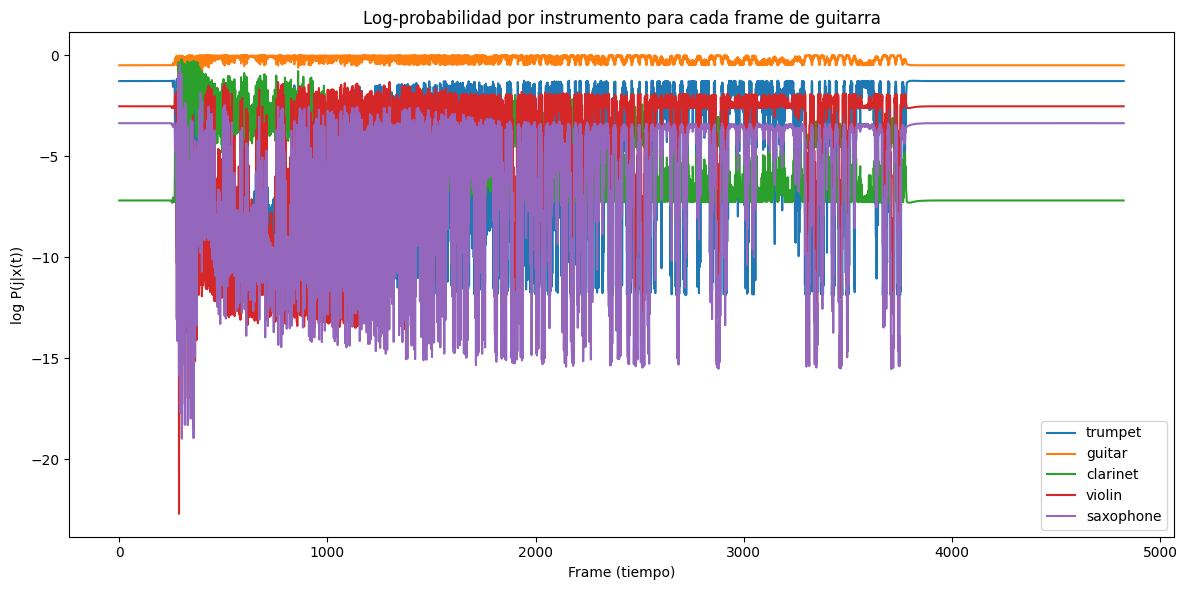

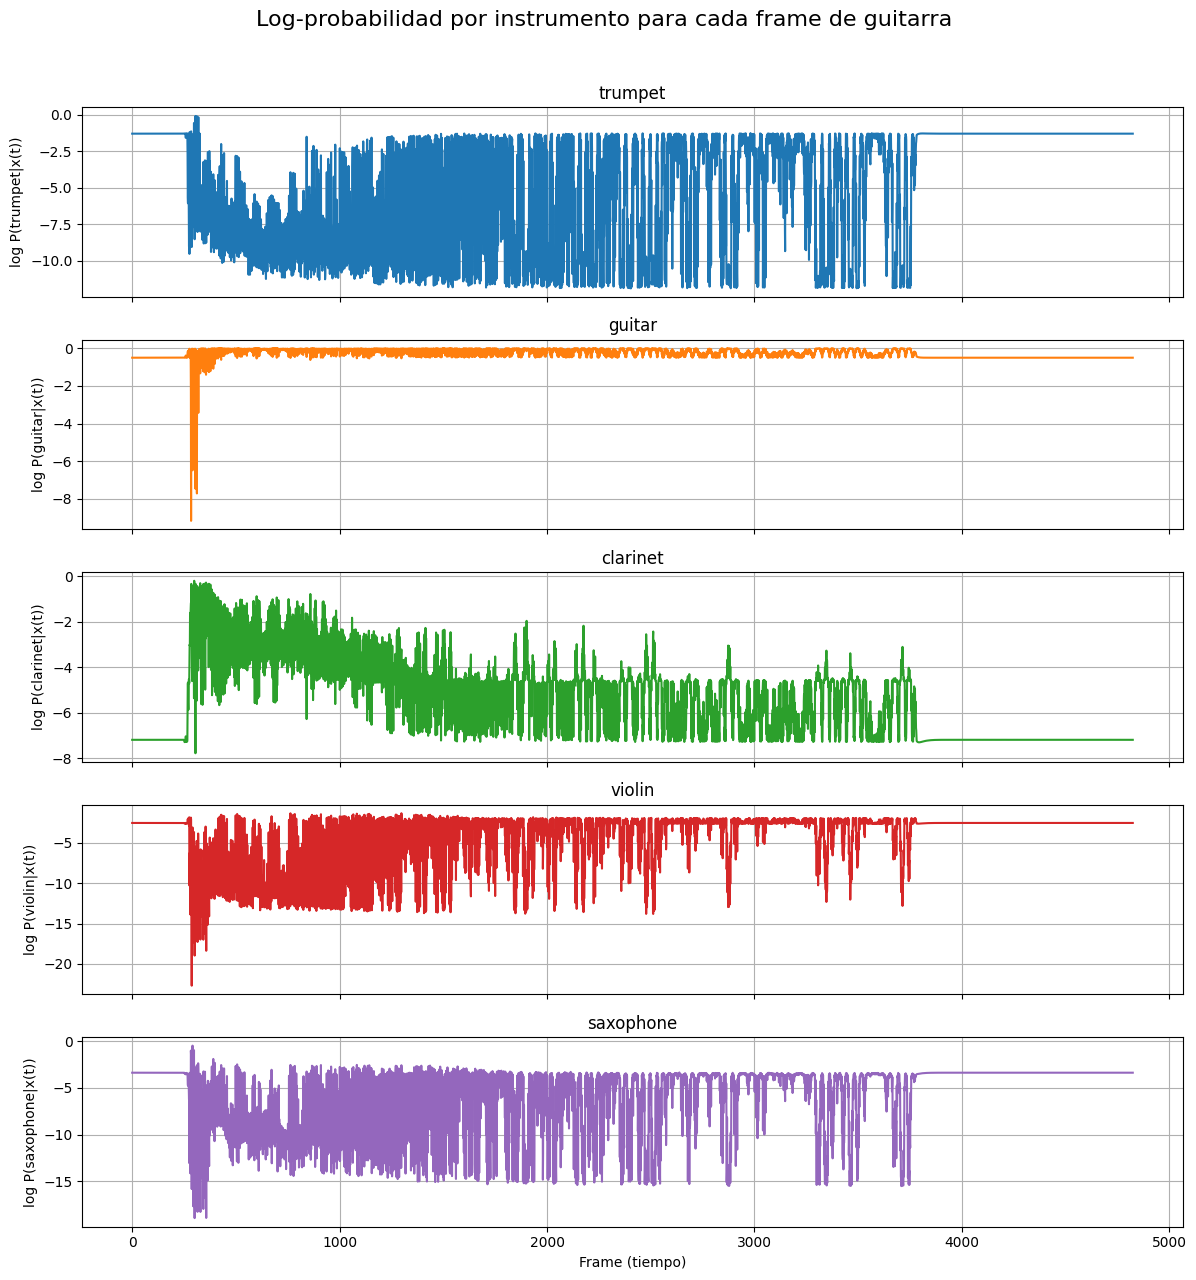

In [65]:
# 1. Extraer frames de guitarra
X_guitarra = spectrograms['guitar']
num_frames = X_guitarra.shape[0]
instrumentos = list(gmm_models.keys())

# 2. Log-priors
num_samples = np.array([spectrograms[inst].shape[0] for inst in instrumentos])
priors = num_samples / num_samples.sum()
log_priors = np.log(priors)

# 3. Para cada frame, calcular log P(j|x(t))
log_posteriors = np.zeros((num_frames, len(instrumentos)))

for t in range(num_frames):
    log_liks = np.array([gmm_models[inst].score_samples(X_guitarra[t:t+1])[0] for inst in instrumentos])
    log_joint = log_liks + log_priors
    log_posteriors[t, :] = log_joint - np.log(np.sum(np.exp(log_joint)))  # log softmax

# 4. Graficar
plt.figure(figsize=(12, 6))
for j, inst in enumerate(instrumentos):
    plt.plot(log_posteriors[:, j], label=inst)
plt.xlabel('Frame (tiempo)')
plt.ylabel('log P(j|x(t))')
plt.title('Log-probabilidad por instrumento para cada frame de guitarra')
plt.legend()
plt.tight_layout()
plt.show()

num_instruments = len(instrumentos)
fig, axes = plt.subplots(num_instruments, 1, figsize=(12, 2.5 * num_instruments), sharex=True)

for j, inst in enumerate(instrumentos):
    ax = axes[j] if num_instruments > 1 else axes
    ax.plot(log_posteriors[:, j], color='C'+str(j))
    ax.set_ylabel(f'log P({inst}|x(t))')
    ax.set_title(f'{inst}')
    ax.grid(True)

axes[-1].set_xlabel('Frame (tiempo)')
plt.suptitle('Log-probabilidad por instrumento para cada frame de guitarra', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()